In [1]:
import os
import shutil
import random

# Thư mục gốc dataset
root_dir = "/kaggle/input/snakevn/VietNam_Snake_DataLast"
output_dir = "/kaggle/working/data"  # nơi lưu sau khi chia

# Tỉ lệ chia
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Tạo thư mục output
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)

# Hàm lấy toàn bộ ảnh trong class (kể cả folder con)
def get_all_images_in_class(class_dir):
    image_files = []
    for root, dirs, files in os.walk(class_dir):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_files.append(os.path.join(root, f))
    return image_files

# Lặp qua từng class folder
for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    images = get_all_images_in_class(class_dir)

    if len(images) == 0:
        print(f"⚠️ Class {class_name} không có ảnh, bỏ qua.")
        continue

    random.shuffle(images)

    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val

    train_files = images[:n_train]
    val_files = images[n_train:n_train+n_val]
    test_files = images[n_train+n_val:]

    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for src in split_files:
            dst = os.path.join(split_class_dir, os.path.basename(src))
            shutil.copy2(src, dst)

print("✅ Done! Dataset đã được chia vào thư mục '/kaggle/working/data/train', 'val', 'test'")


✅ Done! Dataset đã được chia vào thư mục '/kaggle/working/data/train', 'val', 'test'


In [2]:
import os
import hashlib
from collections import defaultdict

# Thư mục dataset
data_root = "/kaggle/working/data"

def file_hash(path):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            h.update(chunk)
    return h.hexdigest()

# 1. Tạo hash cho train
train_hashes = {}
for root, dirs, files in os.walk(os.path.join(data_root, "train")):
    for f in files:
        if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            path = os.path.join(root, f)
            h = file_hash(path)
            train_hashes[h] = path  # chỉ giữ 1 path đại diện trong train

# 2. So sánh val/test với train
leak_dict = defaultdict(list)
for split in ["val", "test"]:
    split_dir = os.path.join(data_root, split)
    for root, dirs, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                path = os.path.join(root, f)
                h = file_hash(path)
                if h in train_hashes:  # nếu hash trùng với ảnh train
                    leak_dict[h].append((train_hashes[h], path))

# 3. Báo cáo leak
print(f"🔎 Tổng số nhóm leak (val/test vs train): {len(leak_dict)}\n")

for h, pairs in leak_dict.items():
    print(f"--- Hash: {h} ---")
    for p in pairs:
        print(f"Train: {p[0]}")
        print(f"Leak : {p[1]}")
        print()

# 4. Xoá ảnh leak trong val/test
delete_count = 0
for h, pairs in leak_dict.items():
    for train_path, leak_path in pairs:
        try:
            os.remove(leak_path)
            delete_count += 1
            print(f"🗑️ Deleted leak: {leak_path}")
        except Exception as e:
            print(f"❌ Error deleting {leak_path}: {e}")

print(f"\n✅ Đã xoá {delete_count} ảnh leak khỏi val/test.\n")

# 5. Check lại sau khi xoá
leak_dict_check = defaultdict(list)
for split in ["val", "test"]:
    split_dir = os.path.join(data_root, split)
    for root, dirs, files in os.walk(split_dir):
        for f in files:
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
                path = os.path.join(root, f)
                h = file_hash(path)
                if h in train_hashes:
                    leak_dict_check[h].append((train_hashes[h], path))

print(f"🔎 Sau khi xoá, số nhóm leak còn lại: {len(leak_dict_check)}")


🔎 Tổng số nhóm leak (val/test vs train): 61

--- Hash: 438c578e035b4d552d6b08c9ce3b5a4a ---
Train: /kaggle/working/data/train/Oreocryptophis_porphyraceus/150486480_0.jpg
Leak : /kaggle/working/data/val/Oreocryptophis_porphyraceus/152250035_0.jpg

--- Hash: e50467872b4c20378a829353a6962e18 ---
Train: /kaggle/working/data/train/Bungarus_fasciatus/274548348_0.jpg
Leak : /kaggle/working/data/val/Bungarus_fasciatus/276906461_0.jpg

--- Hash: 2db9c856bdba07961a1e4426a13c5547 ---
Train: /kaggle/working/data/train/Lycodon_ruhstrati/224712234_12.jpg
Leak : /kaggle/working/data/val/Lycodon_ruhstrati/218408143_12.jpg

--- Hash: 11a3b89d006b425b022858b6eff0c62f ---
Train: /kaggle/working/data/train/Pareas_carinatus/290649718_1.jpg
Leak : /kaggle/working/data/val/Pareas_berdmorei/290649718_1.jpg

--- Hash: ef3151a13a30c41b5157c4a87e9c2895 ---
Train: /kaggle/working/data/train/Pareas_carinatus/160903201_2.jpg
Leak : /kaggle/working/data/val/Pareas_berdmorei/160903201_2.jpg

--- Hash: 28038c0dbb8cd43

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import os

# =========================
# 1. Config
# =========================
data_dir = "/kaggle/working/data"   # Cấu trúc thư mục: data/train, data/val
num_classes = 124
batch_size = 32
num_epochs = 30
lr = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 2. Data Augmentation
# =========================
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# =========================
# 3. Model
# =========================
model = models.swin_t(weights="IMAGENET1K_V1")  # pretrained Swin-Tiny
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# =========================
# 4. Loss, Optimizer, Scheduler
# =========================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# =========================
# 5. Training Loop
# =========================
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Thêm history để vẽ sau này
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Lưu history
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            
            # Save best
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        # ================================
        # 🔹 Lưu model sau mỗi 5 epoch
        # ================================
        if (epoch + 1) % 5 == 0:
            save_path = f"/kaggle/working/swin_tiny_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), save_path)
            print(f"✅ Saved model at {save_path}")
        
        print()
    
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# =========================
# 6. Run Training
# =========================
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Save final best model
torch.save(model.state_dict(), "/kaggle/working/swin_tiny_best.pth")



Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 175MB/s]  


Epoch 1/30
--------------------
train Loss: 2.6701 Acc: 0.4704
val Loss: 1.7186 Acc: 0.7126

Epoch 2/30
--------------------
train Loss: 1.8725 Acc: 0.6852
val Loss: 1.4697 Acc: 0.7991

Epoch 3/30
--------------------
train Loss: 1.6699 Acc: 0.7490
val Loss: 1.4266 Acc: 0.8112

Epoch 4/30
--------------------
train Loss: 1.5599 Acc: 0.7827
val Loss: 1.3455 Acc: 0.8379

Epoch 5/30
--------------------
train Loss: 1.4630 Acc: 0.8142
val Loss: 1.2852 Acc: 0.8548
✅ Saved model at /kaggle/working/swin_tiny_epoch5.pth

Epoch 6/30
--------------------
train Loss: 1.4160 Acc: 0.8265
val Loss: 1.2460 Acc: 0.8727

Epoch 7/30
--------------------
train Loss: 1.3767 Acc: 0.8397
val Loss: 1.2574 Acc: 0.8656

Epoch 8/30
--------------------
train Loss: 1.3101 Acc: 0.8598
val Loss: 1.2174 Acc: 0.8767

Epoch 9/30
--------------------
train Loss: 1.2852 Acc: 0.8689
val Loss: 1.1929 Acc: 0.8899

Epoch 10/30
--------------------
train Loss: 1.2617 Acc: 0.8726
val Loss: 1.1794 Acc: 0.8923
✅ Saved model at

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# =========================
# 7. Evaluation on Test Set
# =========================
# Load lại test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lấy mapping index -> class name
class_names = test_dataset.classes
num_classes = len(class_names)

# Load best model đã save
model.load_state_dict(torch.load("/kaggle/working/swin_tiny_best.pth"))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# =========================
# 8. Tính accuracy
# =========================
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {overall_acc:.4f}")

# =========================
# 9. Accuracy từng class
# =========================
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("\nAccuracy theo từng class:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
    correct = np.sum(all_preds[idx] == all_labels[idx])
    total = np.sum(idx)
    print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")

# =========================
# 10. Classification Report (optional)
# =========================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))



Test Accuracy: 0.9257

Accuracy theo từng class:
Achalinus_rufescens        Acc: 1.0000  (13/13)
Achalinus_spinalis         Acc: 0.9286  (13/14)
Acrochordus_granulatus     Acc: 0.9767  (42/43)
Acrochordus_javanicus      Acc: 0.6250  (5/8)
Ahaetulla_fusca            Acc: 0.8519  (23/27)
Ahaetulla_prasina          Acc: 0.9500  (19/20)
Ahaetulla_rufusoculara     Acc: 0.8889  (8/9)
Amphiesma_stolatum         Acc: 0.9474  (72/76)
Blue-lipped_sea_krait      Acc: 0.9506  (77/81)
Boiga_cyanea               Acc: 0.9500  (76/80)
Boiga_guangxiensis         Acc: 1.0000  (8/8)
Boiga_jaspidea             Acc: 1.0000  (41/41)
Boiga_kraepelini           Acc: 0.9701  (65/67)
Boiga_multomaculata        Acc: 0.9700  (97/100)
Boiga_siamensis            Acc: 0.9032  (28/31)
Bungarus_candidus          Acc: 0.9859  (70/71)
Bungarus_fasciatus         Acc: 0.9885  (86/87)
Calamaria_septentrionalis  Acc: 0.8636  (19/22)
Calliophis_maculiceps      Acc: 1.0000  (17/17)
Calloselasma_rhodostoma    Acc: 0.9703  (98

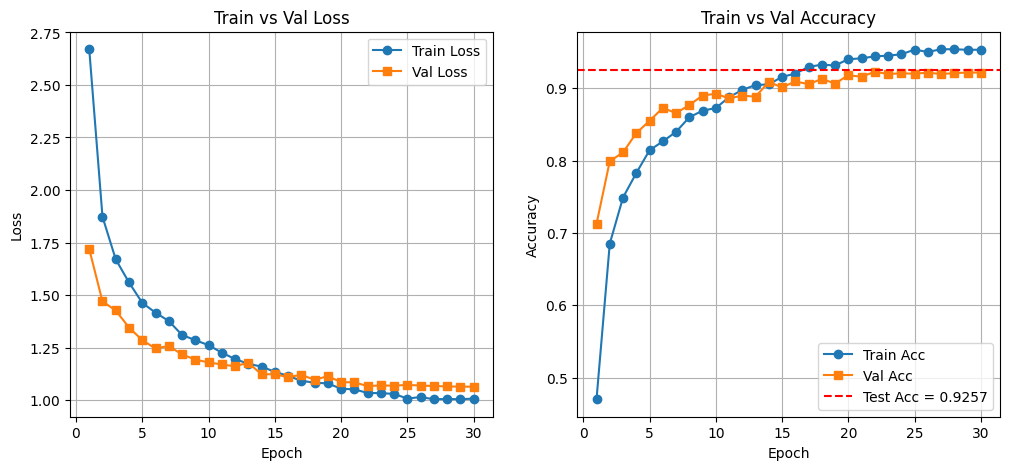

In [5]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs, history["train_loss"], 'o-', label="Train Loss")
plt.plot(epochs, history["val_loss"], 's-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history["train_acc"], 'o-', label="Train Acc")
plt.plot(epochs, history["val_acc"], 's-', label="Val Acc")
plt.axhline(y=overall_acc, color='r', linestyle='--', label=f"Test Acc = {overall_acc:.4f}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [6]:
print("\n⚠️ Các class dưới 70% accuracy:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
        correct, total = 0, 0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
        correct = np.sum(all_preds[idx] == all_labels[idx])
        total = np.sum(idx)

    if acc < 0.7:  # dưới 70%
        print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")



⚠️ Các class dưới 70% accuracy:
Acrochordus_javanicus      Acc: 0.6250  (5/8)
Erpeton_tentaculatum       Acc: 0.4444  (4/9)
Gonyosoma_frenatum         Acc: 0.6250  (5/8)
Hebius_optatus             Acc: 0.6667  (4/6)
Oligodon_cyclurus          Acc: 0.6000  (6/10)
Pareas_hamptoni            Acc: 0.1429  (1/7)
Pareas_monticola           Acc: 0.6000  (3/5)
Sinomicrurus_peinani       Acc: 0.6250  (5/8)
Trimeresurus_albolabris    Acc: 0.6875  (11/16)


In [15]:
import torch
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# =====================
# Load model
# =====================
num_classes = 124
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Khởi tạo lại model giống lúc train
model = models.swin_t(weights=None)   # không load pretrained vì ta đã có weight rồi
model.head = nn.Linear(model.head.in_features, num_classes)

# Load weight đã train
model.load_state_dict(torch.load("/kaggle/working/swin_tiny_best.pth", map_location=device))
model = model.to(device)
model.eval()

# =====================
# Transform cho ảnh test
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize giống input khi train
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# =====================
# Predict từ link ảnh
# =====================
def predict_from_url(url, class_names):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # thêm batch dimension

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()
    
    print(f"Predicted class: {class_names[pred_idx]} (prob = {probs[0][pred_idx]:.4f})")
    return class_names[pred_idx]

# =====================
# Ví dụ chạy thử
# =====================
# Lấy tên class từ ImageFolder
class_names = image_datasets['train'].classes  

url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFuI1z0kcbSqY4aipR3sB0NoiGcbfhirWKoc4cSn7hCxP1pdY70jOmFenB74wUD6ZSYFRjzd38FCzkeogaji8JvEjQeiL_4-KeTbKVe1E"
predict_from_url(url, class_names)


Predicted class: Lycodon_chapaensis (prob = 0.6954)


'Lycodon_chapaensis'